# Exploring Mental Health Data
**Feature Engineering step**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
# Sử dụng data preprocesing
df = pd.read_csv("data/cleaned_train.csv")

In [3]:
df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,8.5,Healthy,NaN,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,4.5,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5.5,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,4.5,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5.5,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140651,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5.5,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140652,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7.5,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140653,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,8.5,Moderate,B.Com,No,4.0,4.0,No,0
140654,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5.5,Moderate,ME,Yes,10.0,1.0,No,0


# 1. Loại bỏ các đặc trưng không cần thiết
Đống thời tách data và target thành `X` và `y`

In [4]:
X = df.drop(columns=["Depression", "id", "Name"])
y = df["Depression"]

# 2. Tạo các đặc trưng mới

Tùy theo người `đi học` hay `đi làm` mà các cột `'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'` có giá trị hay không.

Dựa trên điểm chung `Stress` hay `Satisfaction`, ta kết hợp 2 cột với nhau thành `'Aca/Work Pressure','Aca/Work Satisfaction'` đồng thời khử các giá trị NULL chưa thể xử lí.

In [5]:
X['Aca/Work Pressure'] = X['Academic Pressure'].fillna(X['Work Pressure'])
X['Aca/Work Satisfaction'] = X['Study Satisfaction'].fillna(X['Job Satisfaction'])
X.drop(columns=['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'], inplace=True)

# 3. Encoding

Ở bộ dataset này, chủ yếu các cột thuộc dạng Categorical và nhiều cột chứa rất nhiều nhóm.
\\
Điều này khiến việc encoding các cột như trên khó khăn. Vì thế, trong trường hợp này, nhóm tiếp cận bằng cách chia thành 2 bộ dữ liệu để feature engineering:
- Bộ không encoding `X1`: Cho phương pháp model-based có thể xử lí Categorical data không cần encoding (CatBoost, LightGBM, ...)
- Bộ encoding `X2` (bỏ những đặc trưng không thể encoding): được encoding và normalize.

In [6]:
X1 = X.copy()

In [7]:
catgegorical_features = [
    'Working Professional or Student',
    'Gender',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?',
    'Dietary Habits',
    'City',
    'Degree',
    'Profession']

In [8]:
for col in catgegorical_features:
    X1[col] = X1[col].fillna('NaN')
    X1[col] = X1[col].astype('category')

In [9]:
X2 = X.copy()

In [10]:
X2['Working Professional or Student'] = X2['Working Professional or Student'].map({'Working Professional': True, 'Student': False})
X2['Gender'] = X2['Gender'].map({'Male': True, 'Female': False})

In [11]:
X2['Family History of Mental Illness'] = X2['Family History of Mental Illness'].map({'Yes': True, 'No': False})
X2['Have you ever had suicidal thoughts ?'] = X2['Have you ever had suicidal thoughts ?'].map({'Yes': True, 'No': False})

Dietary Habits chuyển thành -1 / 0 / 1

In [12]:
X2['Dietary Habits'] = X2['Dietary Habits'].map({'Unhealthy': -1, 'Moderate': 0, 'Healthy': 1})

In [13]:
X2 = X2.drop(columns=['City', 'Degree', 'Profession'])

In [14]:
X2 = X2.drop(columns=['CGPA'])

Chuẩn hóa dữ liệu

In [15]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
X2 = pd.DataFrame(scaler2.fit_transform(X2), columns=X2.columns)

Cuối cùng, ta có riêng 2 bộ dữ liệu sau:

In [16]:
X1.head(3)

,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Aca/Work Pressure,Aca/Work Satisfaction
0,Female,49.0,Ludhiana,Working Professional,Chef,NaN,8.5,Healthy,NaN,No,1.0,2.0,No,5.0,2.0
1,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.5,Unhealthy,LLB,Yes,7.0,3.0,No,4.0,3.0
2,Male,33.0,Visakhapatnam,Student,NaN,8.97,5.5,Healthy,B.Pharm,Yes,3.0,1.0,No,5.0,2.0


In [17]:
X2.head(3)

,Gender,Age,Working Professional or Student,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Aca/Work Pressure,Aca/Work Satisfaction
0,-1.106832,0.695152,0.497230,1.291788,1.256724,-0.988843,-1.363057,-0.699562,-0.994272,1.407100,-0.689290
1,0.903480,-1.162225,0.497230,-1.226583,-1.230514,1.011283,0.193972,0.007836,-0.994272,0.693793,0.022342
2,0.903480,-0.596936,-2.011141,-0.596991,1.256724,1.011283,-0.844047,-1.406960,-0.994272,1.407100,-0.689290


In [18]:
print("Shape of X1:", X1.shape)
print("Shape of X2:", X2.shape)

Shape of X1: (140656, 15)
Shape of X2: (140656, 11)


# 4. Chọn lựa đặc trưng

Nhóm kết hợp sử dụng 3 chiến lược sau:
- Dựa vào correlation matrix (ma trận tương quan).
- Dùng statistical tests.
- Dùng model-based methodd.

## 4.1. Correlation matrix

In [19]:
import seaborn as sns

In [20]:
df_cor = pd.concat([X2, y], axis=1)

<Axes: >

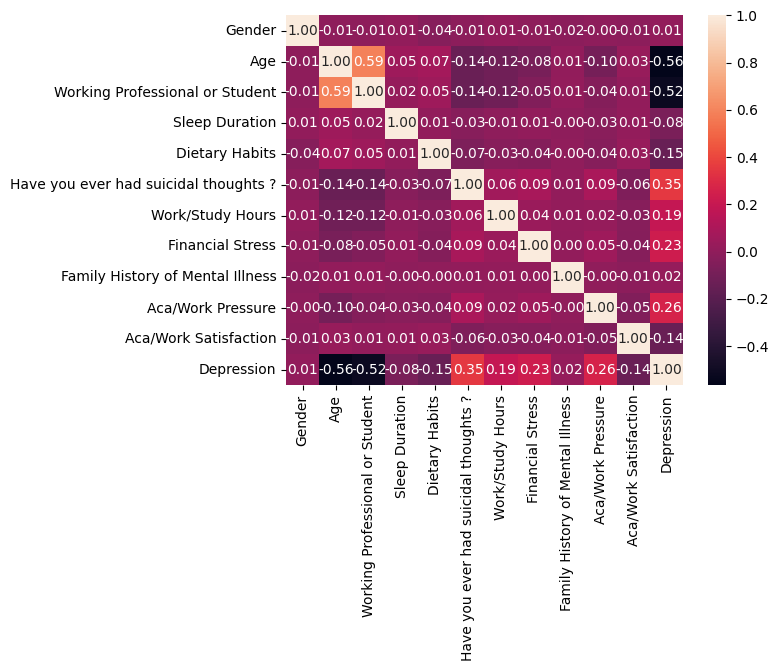

In [21]:
heatmap = df_cor.corr()
sns.heatmap(heatmap, annot=True, fmt=".2f")

Ở đây, ta thấy 2 cột `Age` và `Working Professional or Student` có tương quan cao hơn hẳn với các cột khác.

**Việc drop 1 trong 2 cột này là không nên**, vì:
- Tương quan của 2 cột này đối với cột target là rất cao sao với các cột khác.
- Mặc dù Age và Working Professional or Student có tương quan 0.59, nhưng không phải là (0.8 - 0.9) tức là vẫn còn thông tin riêng biệt ở mỗi cột. Ví dụ: Hai người cùng là "Working Professional" nhưng tuổi có thể rất khác nhau.
- `Age` là một biến định lượng (số tuổi cụ thể). `Working Professional or Student` là một biến phân loại
- Ngưỡng tương quan chưa đủ cao 0.59 chưa tới (>0.8)

Family History of Mental Illness và Gender có tương quan với cột mục tiêu Depression rất thấp 0.01 và 0.02. Cân nhắc loại bỏ 2 features này.

## 4.2. Statistical tests

### Chi-squared test

In [ ]:
df1 = pd.concat([X1, y], axis=1)

In [ ]:
# Chuyển dữ liệu về str
for column in df1.columns:
       if column != 'Depression':
           df1[column] = df1[column].astype(str)
df1['Depression'] = df1['Depression'].astype(str)

In [ ]:
import scipy.stats as stats

def chi_square_test(df, target_column):
    results = {}
    for column in df.columns:
        if column != target_column and df[column].dtype == 'object':
            contingency_table = pd.crosstab(df[column], df[target_column])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            results[column] = {'chi2': chi2, 'p-value': p, 'dof': dof}
    return results


target_variable = 'Depression'

# Tính Chi2
chi2_results = chi_square_test(df1, target_variable)


for feature, result in chi2_results.items():
  print(f"Chi-square test for feature: {feature}")
  print(f"  Chi2 statistic: {result['chi2']}")
  print(f"  P-value: {result['p-value']}")
  print(f"  Degrees of freedom: {result['dof']}")
  print("-" * 20)

Chi-square test for feature: Gender
  Chi2 statistic: 9.556563770991076
  P-value: 0.001992357126098118
  Degrees of freedom: 1
--------------------
Chi-square test for feature: Age
  Chi2 statistic: 56175.56135294131
  P-value: 0.0
  Degrees of freedom: 42
--------------------
Chi-square test for feature: City
  Chi2 statistic: 1057.295539495452
  P-value: 4.0433885983062966e-203
  Degrees of freedom: 30
--------------------
Chi-square test for feature: Working Professional or Student
  Chi2 statistic: 38163.30526609875
  P-value: 0.0
  Degrees of freedom: 1
--------------------
Chi-square test for feature: Profession
  Chi2 statistic: 41987.347196946524
  P-value: 0.0
  Degrees of freedom: 35
--------------------
Chi-square test for feature: CGPA
  Chi2 statistic: 39044.38556135929
  P-value: 0.0
  Degrees of freedom: 331
--------------------
Chi-square test for feature: Sleep Duration
  Chi2 statistic: 1196.532558971001
  P-value: 8.992406925903314e-258
  Degrees of freedom: 4
-----

In [ ]:
# Kết quả Chi2 test
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')
chi2_df = chi2_df.sort_values(by='chi2', ascending=False)
chi2_df


,chi2,p-value,dof
Age,56175.5613529413,0.0000000000,42
Profession,41987.3471969465,0.0000000000,35
CGPA,39044.3855613593,0.0000000000,331
Working Professional or Student,38163.3052660988,0.0000000000,1
Have you ever had suicidal thoughts ?,17137.3040843955,0.0000000000,1
Degree,13001.1035321525,0.0000000000,24
Aca/Work Pressure,10156.5623298798,0.0000000000,4
Financial Stress,7724.4202724866,0.0000000000,4
Work/Study Hours,6322.3921515647,0.0000000000,12
Dietary Habits,3244.7325773756,0.0000000000,3


**Nhận xét**:
 - Tất cả các biến đều có mối liên hệ thống kê với Depression (p-value < 0.05)
 - Nhóm có Chi² càng lớn (và p-value ≈ 0) như Age, Profession, CGPA, Working Professional or Student, Have you ever had suicidal thoughts?,… cho thấy mối liên hệ từ mạnh tới rất mạnh với nguy cơ trầm cảm.

- Ngược lại, những biến như Gender và Family History of Mental Illness có Chi² nhỏ hơn đáng kể, nghĩa là mức độ liên hệ khiêm tốn hơn so với các yếu tố khác, nhưng vẫn có ý nghĩa thống kê.

### ANOVA test

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
df2 = pd.concat([X2, y], axis=1)
X_2 = df2.drop(columns=['Depression'])
y_2 = df2['Depression']

In [ ]:
X_2 = X_2.dropna()
y_2 = y_2[y_2.index.isin(X_2.index)]

In [ ]:
# Tính F-value và p-value
F, p = f_classif(X_2,y_2)

# Đưa vào DataFrame cho dễ xem
anova_result = pd.DataFrame({'Feature': X_2.columns, 'F_value': F, 'p_value': p})
anova_result['p_value'] = anova_result['p_value'].apply(lambda x: format(x, '.10f'))
anova_result = anova_result.sort_values(by='F_value', ascending=False)

print(anova_result)

                                  Feature          F_value       p_value
1                                     Age 65802.6336920452  0.0000000000
2         Working Professional or Student 52343.1396229648  0.0000000000
5   Have you ever had suicidal thoughts ? 19511.7130052825  0.0000000000
9                       Aca/Work Pressure 10490.0216137783  0.0000000000
7                        Financial Stress  7648.7928385769  0.0000000000
6                        Work/Study Hours  5369.2164181235  0.0000000000
4                          Dietary Habits  3193.6437369587  0.0000000000
10                  Aca/Work Satisfaction  2910.4295189559  0.0000000000
3                          Sleep Duration   811.1455317116  0.0000000000
8        Family History of Mental Illness    38.7562635030  0.0000000005
0                                  Gender     9.6377585046  0.0019065556


**Nhận xét**:
Các feature có giá trị F_value cao (F_value > 100) và p_value thấp (p_value < 0.01) như:
- Age
- Working Professional or Student
- Have you ever had suicidal thoughts?
- Aca/Work Pressure
- Financial Stress
- Work/Study Hours
- Aca/Work Satisfaction
- Dietary Habits
- Sleep Duration

Có sự khác biệt giữa các nhóm lớn hơn nhiều so với độ biến thiên trong cùng một nhóm. Tức Feature đó phân biệt tốt giữa các nhãn.

Có khả năng sự khác biệt do ngẫu nhiên rất thấp. Feature thật sự liên quan đến nhãn và nên được giữ lại

Tuy nhiên, cột:

 Family History of Mental Illness và Gender có F_value không quá cao (< 100) nhưng p_value thấp (< 0.01) nên cần được kết hợp thêm với các chiến lược khác để quyết định có nên loại bỏ hay không

## 4.3. Model-based method

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2,random_state=0)


### Lựa chọn đặc trưng dựa trên Logistic Regression

In [ ]:
df2 = pd.concat([X2, y], axis=1)
df2 = df2.dropna()

X2 = df2.drop('Depression', axis=1)
y = df2['Depression']

In [ ]:
# Huấn luyện mô hình Logistic Regression với phạt L1
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2)
log_reg = LogisticRegression(penalty='l1',C=1 ,solver='liblinear',class_weight='balanced', random_state= 42)
log_reg.fit(X2, y)

LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
# Chọn lọc đặc trưng
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(log_reg, prefit=True)
X2_selected = selector.transform(X2)

# Lấy chỉ số của các feature được chọn
selected_feature_indices = selector.get_support(indices=True)
print("Chỉ số các feature được chọn:", selected_feature_indices)

# Lấy tên của các feature được chọn
selected_feature_names = X2.columns[selector.get_support()]

Chỉ số các feature được chọn: [ 0  1  2  3  4  5  6  7  8  9 10]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# Lấy hệ số của các feature và sắp xếp theo mức độ quan trọng
feature_importance = log_reg.coef_[0]
sorted_idx = np.argsort(np.abs(feature_importance))[::-1]
sorted_feature_names = X2.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

print("\nDanh sách sắp xếp mức độ quan trọng:")
for i in range(len(sorted_feature_names)):
    print(f"{sorted_feature_names[i]}: {sorted_importance[i]}")


Danh sách sắp xếp mức độ quan trọng:
Age: -2.1098170454965897
Have you ever had suicidal thoughts ?: 1.2155010015562149
Aca/Work Pressure: 0.9830880088012385
Working Professional or Student: -0.7723623953289446
Financial Stress: 0.7637718291113118
Aca/Work Satisfaction: -0.5749344540700725
Work/Study Hours: 0.5055822015726451
Dietary Habits: -0.4173640143898708
Sleep Duration: -0.25253660496439934
Family History of Mental Illness: 0.10709593512211742
Gender: 0.0016032300104150885


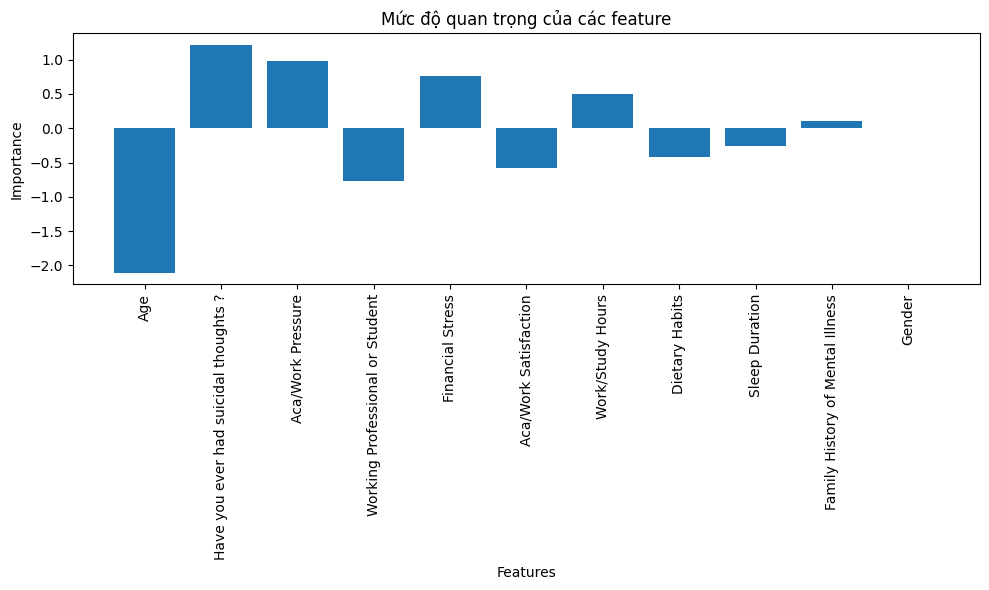

In [ ]:
# Vẽ biểu đồ thể hiện mức độ quan trọng của các feature
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Mức độ quan trọng của các feature")
plt.tight_layout()
plt.show()

# Nhận xét:
1. Top 5 biến ảnh hưởng mạnh nhất:
- Age (~-2.11)
- Have you ever had suicidal thoughts ? (~1.22)
- Aca/Work Pressure (~0.98)
- Working Professional or Student (~-0.77)
- Financial Stress (~0.76)

→ Đây là những biến có giá trị tuyệt đối của hệ số lớn nhất, nghĩa là mỗi biến này sẽ có ảnh hưởng mạnh nhất đến việc bị trầm cảm.

2. Các biến ở mức trung bình:
- Aca/Work Satisfaction (~-0.58)
- Work/Study Hours (~0.51)
- Dietary Habits (~-0.42)
- Sleep Duration (~-0.25)

→ Vẫn có đóng góp nhưng không nổi bật bằng nhóm trên. Có thể cân nhắc giữ lại nếu muốn phân tích toàn diện, hoặc bỏ bớt nếu cần đơn giản hóa mô hình.

3. Các biến ít quan trọng:
- Family History of Mental Illness (~0.11)
- Gender (~0.002)

→ Hệ số nhỏ, cho thấy đóng góp rất yếu. Có thể cân nhắc loại bỏ để giảm số chiều và giúp cho mô hình đơn giản dễ hiểu hơn.

In [ ]:
# Thử siết chặt phạt L1 hơn bằng cách chỉnh tham số C
from sklearn.metrics import accuracy_score, f1_score, recall_score

for C in [1.0, 0.1, 0.01, 0.001]:
    lr = LogisticRegression(penalty='l1', solver='liblinear',class_weight= 'balanced', C=C, random_state=42)
    lr.fit(X2_train, y2_train)

    y2_pred = lr.predict(X2_test)
    accuracy = accuracy_score(y2_test, y2_pred)
    f1 = f1_score(y2_test, y2_pred)
    recall = recall_score(y2_test, y2_pred)

    nonzero = np.sum(np.abs(lr.coef_[0]) > 1e-6)
    print(f"C = {C:<6} → số feature còn lại: {nonzero}, Accuracy: {accuracy}, F1-score: {f1}, Recall: {recall:.4f}")

C = 1.0    → số feature còn lại: 11, Accuracy: 0.9131393611723696, F1-score: 0.7912820512820513, Recall: 0.9271
C = 0.1    → số feature còn lại: 11, Accuracy: 0.9130326527708615, F1-score: 0.7910792104588567, Recall: 0.9271
C = 0.01   → số feature còn lại: 10, Accuracy: 0.9123924023618126, F1-score: 0.7900792636154437, Recall: 0.9283
C = 0.001  → số feature còn lại: 9, Accuracy: 0.904318133314363, F1-score: 0.7768005310321938, Recall: 0.9375


# Ta thấy:
- Cả 2 giá trị C đầu tiên thì độ chênh lệch của Accuracy, F1-score và Recall là rất nhỏ.
- Recall của C = 0.01 lớn hơn so với 2 C đầu
- Ở C = 0.001, Recall lớn hơn so với 3 C đầu nhưng F1 và accuracy thấp hơn hẳn, Recall lớn nhất



# Nhận xét:
1. Nếu ưu tiên giữ F1-score cao nhất.
→ Chọn C = 1.0 hoặc 0.1.

2. Nếu muốn giảm số feature mà mất rất ít performance.
→ Chọn C = 0.01:

 - Giảm 1 biến (11→10)

 - F1 giảm

 - Recall tăng nhẹ

 - Accuracy giảm không đáng kể

3. Nếu cần tối đa hóa recall (tức muốn bắt thật nhiều ca dương)
→ Chọn C = 0.001 nhưng đánh đổi F1 đáng kể.

# Tóm lại nếu muốn cho mô hình gọn, nhanh, hạn chế bị over-fitting, ta nên chọn C = 0.01 với 10 features

In [ ]:
# sử dụng mô hình Logistic Regression với C=0.01
lr = LogisticRegression(penalty='l1',C=0.01 ,solver='liblinear',class_weight='balanced', random_state= 42)
lr.fit(X2, y)

selector = SelectFromModel(lr, prefit=True)
X2_selected = selector.transform(X2)

# Lấy chỉ số của các feature được chọn
selected_feature_indices = selector.get_support(indices=True)
print("Chỉ số các feature được chọn:", selected_feature_indices)

# Lấy tên của các feature được chọn
selected_feature_names = X2.columns[selector.get_support()]

Chỉ số các feature được chọn: [ 1  2  3  4  5  6  7  8  9 10]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
# Lấy hệ số của các feature và sắp xếp theo mức độ quan trọng
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(np.abs(feature_importance))[::-1]
sorted_feature_names = X2.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

print("\nDanh sách sắp xếp mức độ quan trọng:")
for i in range(len(sorted_feature_names)):
    print(f"{sorted_feature_names[i]}: {sorted_importance[i]}")


Danh sách sắp xếp mức độ quan trọng:
Age: -2.0504185066833824
Have you ever had suicidal thoughts ?: 1.1795994086194124
Aca/Work Pressure: 0.9499365896100785
Working Professional or Student: -0.7515705551634061
Financial Stress: 0.7362753874659385
Aca/Work Satisfaction: -0.5510783441642334
Work/Study Hours: 0.48437472808802445
Dietary Habits: -0.3981540835936136
Sleep Duration: -0.2356163984930744
Family History of Mental Illness: 0.09314009077899892
Gender: 0.0


# Nhận xét: Mô hình với C=0.01 đã bỏ đi feature Gender và như nhận xét phía trên việc loại bỏ feature này không ảnh hưởng quá lớn đối với chất lượng mô hình nhưng cũng giúp mô hình tránh overfitting

### Lựa chọn đặc trưng dựa trên Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Tính toán chỉ số Gini Importance  

Mức độ quan trọng của các feature theo Decision Tree:
                                  Feature   Importance
1                                     Age 0.4508420490
5   Have you ever had suicidal thoughts ? 0.1519516997
6                        Work/Study Hours 0.0771938048
9                       Aca/Work Pressure 0.0704619673
7                        Financial Stress 0.0539127507
10                  Aca/Work Satisfaction 0.0499126724
3                          Sleep Duration 0.0438584132
4                          Dietary Habits 0.0323870264
2         Working Professional or Student 0.0251808441
0                                  Gender 0.0227573099
8        Family History of Mental Illness 0.0215414624


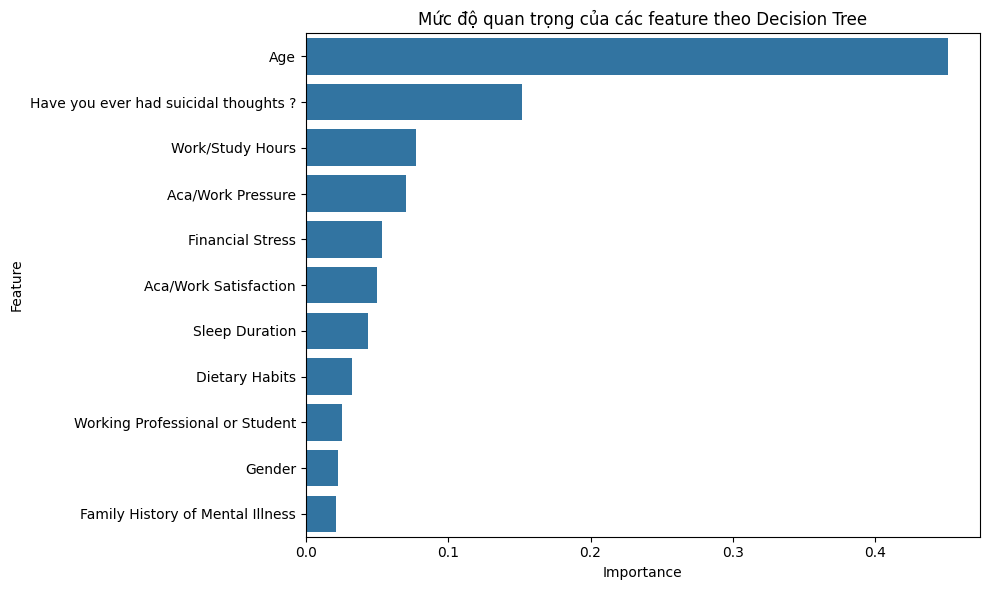

In [ ]:
# Bước 1: Train Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_2, y_2)

# Bước 2: Lấy độ quan trọng của từng feature
feature_importances = tree.feature_importances_

# Bước 3: Đưa vào DataFrame
importance_df = pd.DataFrame({
    'Feature': X_2.columns,
    'Importance': feature_importances
})

# Bước 4: Sắp xếp theo độ quan trọng giảm dần
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Bước 5: In ra, với hiển thị 10 chữ số thập phân (không thay đổi giá trị thực)
pd.set_option('display.float_format', '{:.10f}'.format)
print("Mức độ quan trọng của các feature theo Decision Tree:")
print(importance_df)

# Bước 6: (Option) Vẽ biểu đồ trực quan
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Mức độ quan trọng của các feature theo Decision Tree')
plt.tight_layout()
plt.show()


Age một mình chiếm gần 45%. ➔ Đây là feature cực mạnh trong việc phân loại.
(Có thể do độ tuổi liên quan rất lớn đến stress, áp lực học tập, tâm lý.)

Suicidal thoughts cũng chiếm 15%, và đây là biến quan trọng lâm sàng (cảnh báo nguy cơ tâm lý).

Các feature còn lại như:

Work/Study Hours, Aca/Work Pressure (~7% mỗi cái)

Financial Stress,  Aca/Work Satisfaction (~5% mỗi cái)

→ Góp phần khá tốt, chứng tỏ môi trường học tập/làm việc có ảnh hưởng tâm lý.

Các feature yếu như:

Gender, Family History of Mental Illness, Working Professional or Student

→ Gần như không ảnh hưởng nhiều trong dự đoán (importance chỉ ~2%).

Các feature yếu có mức độ chênh lệch không cao nên khi sử dụng chỉ số threshold để loại bỏ các cột yếu nhất sẽ dẫn đến drop 3 cột cùng một lúc -> Dễ dẫn đến tình trạng overfitting

###Lần lượt bỏ từng feature thấp nhất, train lại model, ghi lại metrics (Accuracy, Recall, F1)

    Num Features     Accuracy       Recall     F1 Score  \
0             11 0.9026819378 0.7379203711 0.7362128808   
1             10 0.9022195348 0.7385001933 0.7354441343   
2              9 0.9017571317 0.7317356011 0.7327269208   
3              8 0.8947143772 0.7139543873 0.7139543873   
4              7 0.8958170307 0.7081561654 0.7144389198   
5              6 0.8974176567 0.6919211442 0.7128634010   
6              5 0.9126413886 0.7249710089 0.7533641293   
7              4 0.9169808636 0.7454580595 0.7677149682   
8              3 0.9173009888 0.7535755702 0.7703250025   
9              2 0.9080529274 0.7895245458 0.7596466760   
10             1 0.8554812549 0.6803247004 0.6340628659   

                         Dropped Features  
0                                      []  
1        Family History of Mental Illness  
2                                  Gender  
3         Working Professional or Student  
4                          Dietary Habits  
5                   Aca/Wor

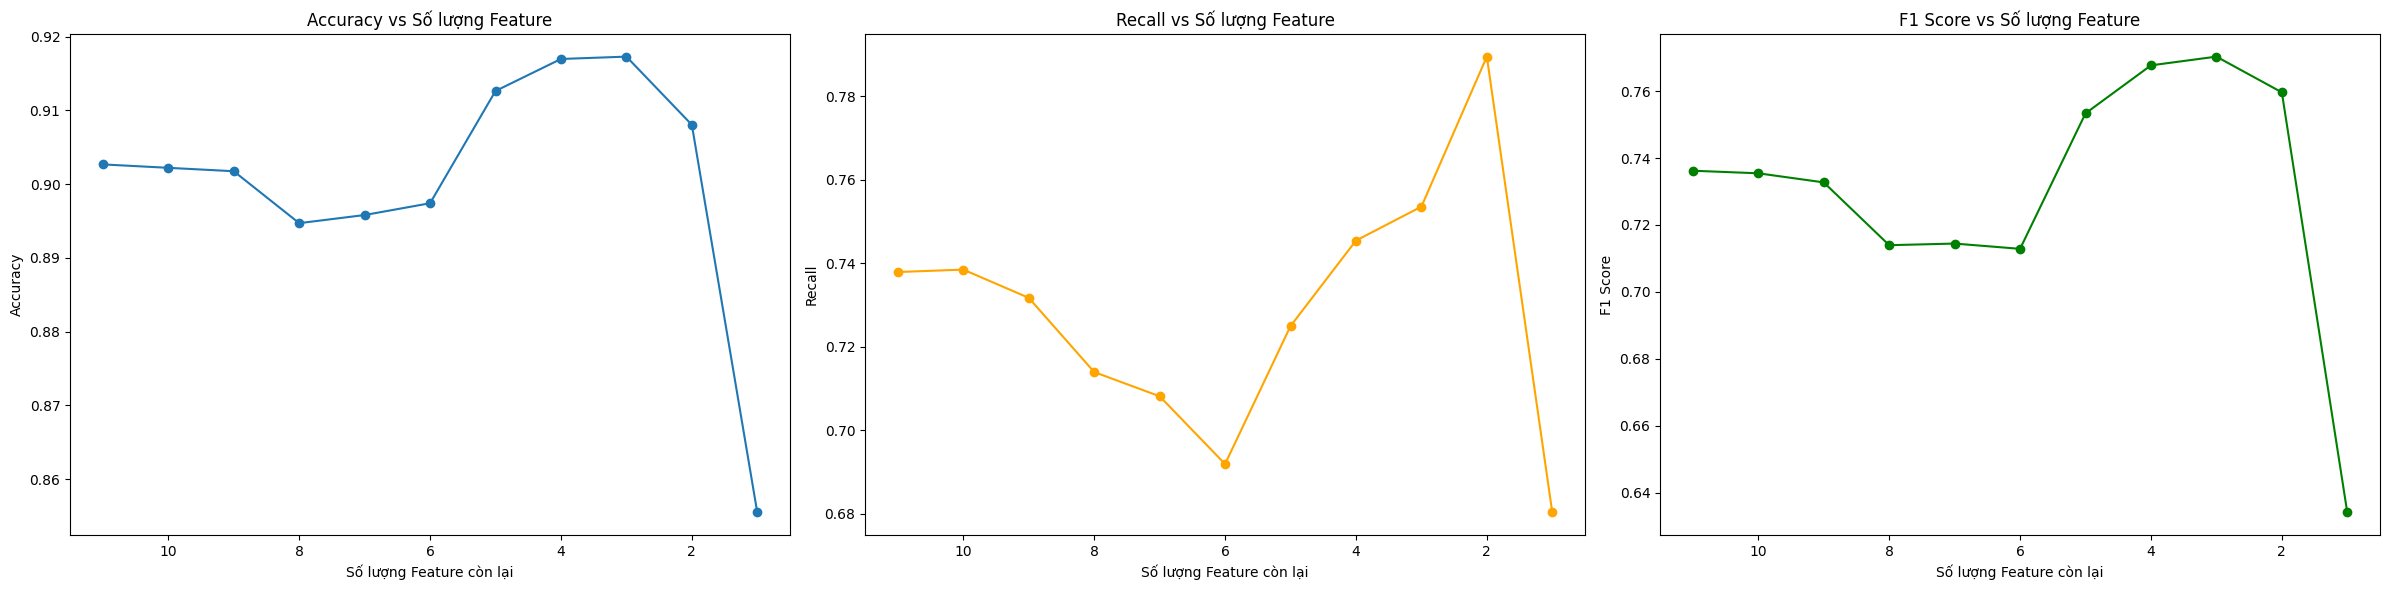

In [ ]:
# 1. Tách train/test
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# 2. Kết quả lưu ở đây
results = []

# 3. Train Decision Tree ban đầu (full features)
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_2_train, y_2_train)
y_pred_full = tree_full.predict(X_2_test)

# Đánh giá
acc_full = accuracy_score(y_2_test, y_pred_full)
f1_full = f1_score(y_2_test, y_pred_full, average='binary')
recall_full = recall_score(y_2_test, y_pred_full, average='binary')

# Lưu kết quả đầu tiên
results.append({
    'Num Features': X_2_train.shape[1],
    'Accuracy': acc_full,
    'Recall': recall_full,
    'F1 Score': f1_full,
    'Dropped Features': []
})

# 4. Bắt đầu quá trình loại dần feature có importance nhỏ nhất
current_features = list(X_2_train.columns)  # bắt đầu với toàn bộ features

while len(current_features) > 1:  # ít nhất còn 1 feature mới tiếp tục
    # Train lại cây với current_features
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_2_train[current_features], y_2_train)

    # Tính importance
    importances = tree.feature_importances_
    feature_importance_dict = dict(zip(current_features, importances))

    # Tìm feature có importance nhỏ nhất
    min_feature = min(feature_importance_dict, key=feature_importance_dict.get)

    # Cập nhật danh sách feature
    dropped_feature = min_feature
    current_features.remove(min_feature)

    # Train lại với feature mới
    tree_selected = DecisionTreeClassifier(random_state=42)
    tree_selected.fit(X_2_train[current_features], y_2_train)

    # Dự đoán
    y_pred = tree_selected.predict(X_2_test[current_features])

    # Đánh giá
    acc = accuracy_score(y_2_test, y_pred)
    f1 = f1_score(y_2_test, y_pred, average='binary')
    recall = recall_score(y_2_test, y_pred, average='binary')

    # Lưu kết quả
    results.append({
        'Num Features': len(current_features),
        'Accuracy': acc,
        'Recall': recall,
        'F1 Score': f1,
        'Dropped Features': dropped_feature
    })

# 5. Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# 6. In kết quả
pd.set_option('display.max_colwidth', None)
print(results_df)

# 7. Vẽ biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(24,6))

# Biểu đồ 1: Accuracy
axes[0].plot(results_df['Num Features'], results_df['Accuracy'], marker='o')
axes[0].set_xlabel('Số lượng Feature còn lại')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Số lượng Feature')
axes[0].invert_xaxis()  # số feature giảm dần

# Biểu đồ 2: Recall
axes[1].plot(results_df['Num Features'], results_df['Recall'], marker='o', color='orange')
axes[1].set_xlabel('Số lượng Feature còn lại')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall vs Số lượng Feature')
axes[1].invert_xaxis()

# Biểu đồ 3: F1 Score
axes[2].plot(results_df['Num Features'], results_df['F1 Score'], marker='o', color='green')
axes[2].set_xlabel('Số lượng Feature còn lại')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score vs Số lượng Feature')
axes[2].invert_xaxis()

plt.tight_layout()
plt.show()

Nếu chọn phương án loại bỏ cột Family History of Mental Illness:

Accuracy: Sau khi loại bỏ cột này, Accuracy gần như không thay đổi nhiều. Điều này cho thấy việc loại bỏ cột này không ảnh hưởng lớn đến hiệu quả chung của mô hình. Điều này có thể vì cột này có importance thấp, nghĩa là nó không đóng góp nhiều vào việc phân loại đúng.

Recall: Recall tăng nhẹ, cho thấy mô hình có khả năng nhận diện chính xác các trường hợp dương tính (positive class) tốt hơn khi bỏ đi "Family History of Mental Illness". Tuy nhiên, sự thay đổi rất nhỏ này không có ý nghĩa lớn.

F1 Score: F1 Score giảm nhẹ, cho thấy có sự giảm nhẹ trong khả năng kết hợp giữa precision và recall. F1 Score thể hiện một sự đánh đổi giữa recall và precision, nên sự giảm này có thể không phải là vấn đề lớn vì sự thay đổi không đáng kể.

Việc loại bỏ cột này không làm giảm đáng kể chất lượng của mô hình, và thậm chí còn có thể giúp mô hình tránh overfitting (do giảm bớt độ phức tạp của mô hình).

### Lựa chọn đặc trưng bằng các mô hình Boosting Tree thông qua kĩ thuật SHAP values

### Giới thiệu

SHAP (SHapley Additive exPlanations) là một phương pháp giải thích mô hình dựa trên lý thuyết trò chơi, gán giá trị tầm quan trọng cho từng đặc trưng dựa trên đóng góp của chúng đến kết quả dự đoán của mô hình.

Dựa trên nghiên cứu “From explanations to feature selection: assessing SHAP values as feature selection mechanism”, nhóm sử dụng giá trị SHAP tính từ mô hình Boosting Tree để đánh giá và chọn ra các đặc trưng quan trọng nhất, giúp tối ưu hóa hiệu suất và giảm độ phức tạp của mô hình.


1. **Huấn luyện mô hình Boosting Tree**  
   Fit mô hình Gradient Boosting (ví dụ XGBoost, LightGBM) trên tập huấn luyện để làm nền tảng cho tính SHAP.

2. **Khởi tạo TreeExplainer**  
   Dùng `shap.TreeExplainer(model)` để chuẩn bị công cụ tính SHAP values cho mô hình tree-based.

3. **Tính SHAP values**  
   Gọi `explainer.shap_values(X)` để thu được ma trận SHAP values (số mẫu × số đặc trưng).

4. **Tổng hợp tầm quan trọng**  
   Tính trung bình tuyệt đối SHAP values mỗi đặc trưng:  
   $$\text{Importance}_j = \frac{1}{N}\sum_{i=1}^N |\,\text{SHAP}_{i,j}|$$  
   để có thứ tự ưu tiên toàn cục.

5. **Chọn đặc trưng**  
   Áp dụng ngưỡng, đánh giá qua performance của model hoặc phân phối elbow.

In [ ]:
!pip install catboost lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Train Boosting tree model

In [ ]:
xgb = XGBClassifier()
xgb.fit(X2_train, y2_train)
print(f"XGBoost Score: {xgb.score(X2_test, y2_test)}")

lbm = LGBMClassifier(verbose=-1)
lbm.fit(X2_train, y2_train)
print(f"LGBM Score: {lbm.score(X2_test, y2_test)}")


XGBoost Score: 0.9374333072490574
LGBM Score: 0.9375044461833961


Áp dụng SHAP values

In [ ]:
import shap

Tính SHAP values cục bộ của từng lớp (`Depression` = 0 || 1)

In [ ]:
X2_test_class0 = X2_test[y2_test.to_numpy() == 0]
X2_test_class1 = X2_test[y2_test.to_numpy() == 1]

In [ ]:
xgb_explainer = shap.TreeExplainer(xgb)

xgb_shap_val_c0 = xgb_explainer.shap_values(X2_test_class0)
xgb_shap_val_c1 = xgb_explainer.shap_values(X2_test_class1)
xgb_importance_c0 = np.abs(xgb_shap_val_c0).mean(0)
xgb_importance_c1 = np.abs(xgb_shap_val_c1).mean(0)

xgb_importance = xgb_importance_c0 + xgb_importance_c1
ordered_features_xgb = pd.Series(xgb_importance, index=X2_test.columns).sort_values(ascending=False).index.tolist()

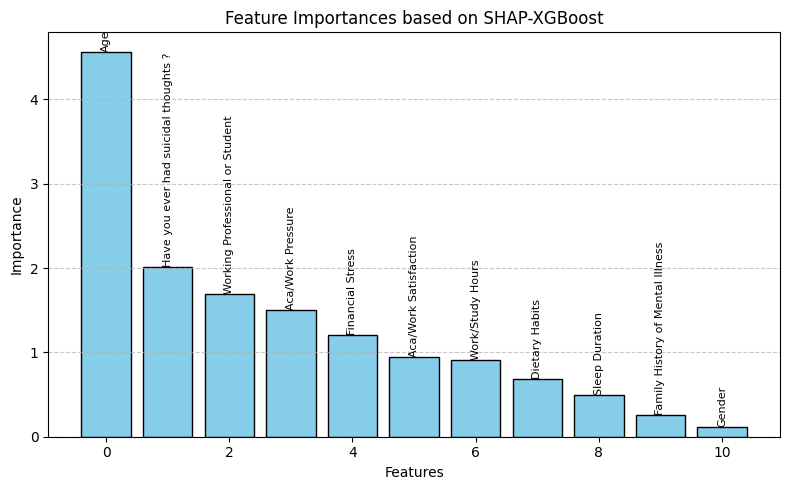

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(xgb_importance)), sorted(xgb_importance)[::-1], color='skyblue', edgecolor='black')
plt.title('Feature Importances based on SHAP-XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.xticks(range(len(xgb_importance)), ordered_features_xgb, rotation=90)

# Annotate bars with feature names
for bar, feature in zip(bars, ordered_features_xgb):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{feature}',
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Chọn `k` đặc trưng dựa trên performance của model trên từng top-k

In [ ]:
def _feature_selection(X, y, Xtest, ytest, model, feature_order):
    k_values = range(1, len(feature_order) + 1, 1)  # Test k = 1, 6, 11, ...
    cv_scores = []

    for k in k_values:
        selected_features = feature_order[:k]
        X_train_subset = X[selected_features]

        model.fit(X_train_subset, y)
        predictions = model.predict(Xtest[selected_features])
        f1 = f1_score(ytest, predictions)
        cv_scores.append(f1)
        print(f"k={k}, CV Accuracy={f1:.4f}")

    # Choose k with the highest score
    optimal_k = k_values[np.argmax(cv_scores)]
    print(f"Optimal k: {optimal_k}")
    print(f"Selected features: {feature_order[:optimal_k]}")
    return feature_order[:optimal_k]

In [ ]:
xgb_subset = _feature_selection(X2_train, y2_train, X2_test, y2_test, XGBClassifier(), ordered_features_xgb)

k=1, CV Accuracy=0.6351
k=2, CV Accuracy=0.7557
k=3, CV Accuracy=0.7492
k=4, CV Accuracy=0.7787
k=5, CV Accuracy=0.8011
k=6, CV Accuracy=0.8083
k=7, CV Accuracy=0.8154
k=8, CV Accuracy=0.8183
k=9, CV Accuracy=0.8200
k=10, CV Accuracy=0.8200
k=11, CV Accuracy=0.8218
Optimal k: 11
Selected features: ['Age', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student', 'Aca/Work Pressure', 'Financial Stress', 'Aca/Work Satisfaction', 'Work/Study Hours', 'Dietary Habits', 'Sleep Duration', 'Family History of Mental Illness', 'Gender']


Cột `Gender` bị loại bỏ và với f1-score cao nhất top-10 feature sẽ được chọn.

**Thử lại với LightGBM**

In [ ]:
lbm_explainer = shap.TreeExplainer(lbm)

lbm_shap_val_c0 = lbm_explainer.shap_values(X2_test_class0)
lbm_shap_val_c1 = lbm_explainer.shap_values(X2_test_class1)
lbm_importance_c0 = np.abs(lbm_shap_val_c0).mean(0)
lbm_importance_c1 = np.abs(lbm_shap_val_c1).mean(0)

lbm_importance = lbm_importance_c0 + lbm_importance_c1
ordered_features_lbm = pd.Series(lbm_importance, index=X2_test.columns).sort_values(ascending=False).index.tolist()

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


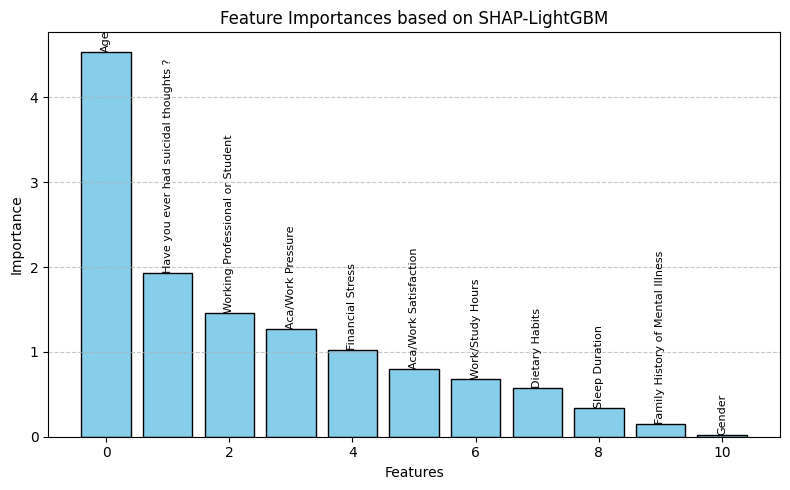

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(lbm_importance)), sorted(lbm_importance)[::-1], color='skyblue', edgecolor='black')
plt.title('Feature Importances based on SHAP-LightGBM')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.xticks(range(len(lbm_importance)), ordered_features_lbm, rotation=90)

# Annotate bars with feature names
for bar, feature in zip(bars, ordered_features_lbm):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{feature}',
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
lbm_subset = _feature_selection(X2_train, y2_train, X2_test, y2_test, LGBMClassifier(), ordered_features_lbm)

k=1, CV Accuracy=0.6351
k=2, CV Accuracy=0.7557
k=3, CV Accuracy=0.7538
k=4, CV Accuracy=0.7793
k=5, CV Accuracy=0.8017
k=6, CV Accuracy=0.8121
k=7, CV Accuracy=0.8180
k=8, CV Accuracy=0.8218
k=9, CV Accuracy=0.8217
k=10, CV Accuracy=0.8220
k=11, CV Accuracy=0.8217
Optimal k: 10
Selected features: ['Age', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student', 'Aca/Work Pressure', 'Financial Stress', 'Aca/Work Satisfaction', 'Work/Study Hours', 'Dietary Habits', 'Sleep Duration', 'Family History of Mental Illness']


LightGBM chỉ chọn top-8 ít hơn XGBoost.

#### Dataset số 1 (chưa encoding)
Trước đó, chúng ta thực hiện trên bộ dataset đã encode và normalize. Tuy nhiên, bộ dữ liệu này không chứa các cột không thể encode `Degree`, `CGPA`, `Profession`. Với kĩ thuật SHAP và model xử lí được categorical data (CatBoost,...), ta có thể đánh giá các cột này.

In [ ]:
cb_x1 = CatBoostClassifier(verbose=0,task_type="GPU", devices='0')
cb_x1.fit(
    X1_train,
    y1_train,
    cat_features=catgegorical_features,
    verbose=0
)
cb_x1.score(X1_test, y1_test)

np.float64(0.9413123844731978)

In [ ]:
X1_test_class0 = X1_test[y1_test.to_numpy() == 0]
X1_test_class1 = X1_test[y1_test.to_numpy() == 1]

In [ ]:
cb_explainer = shap.TreeExplainer(cb_x1)

cb_shap_val_c0 = cb_explainer.shap_values(X1_test_class0)
cb_shap_val_c1 = cb_explainer.shap_values(X1_test_class1)
cb_importance_c0 = np.abs(cb_shap_val_c0).mean(0)
cb_importance_c1 = np.abs(cb_shap_val_c1).mean(0)

cb_importance = cb_importance_c0 + cb_importance_c1
ordered_features_cb = pd.Series(cb_importance, index=X1_test.columns).sort_values(ascending=False).index.tolist()

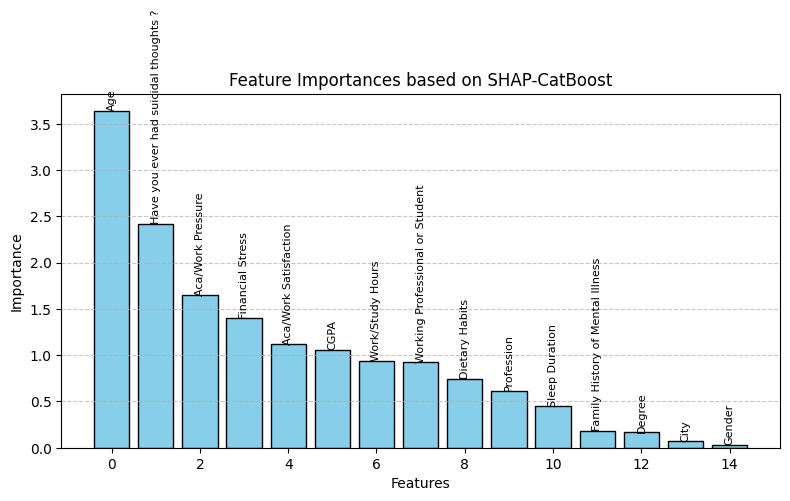

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(cb_importance)), sorted(cb_importance)[::-1], color='skyblue', edgecolor='black')
plt.title('Feature Importances based on SHAP-CatBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
for bar, feature in zip(bars, ordered_features_cb):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{feature}',
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
k_values = range(1, len(ordered_features_cb) + 1, 1)  # Test k = 1, 6, 11, ...
f1_scores = []
recall_scores = []
for k in k_values:
    selected_features = ordered_features_cb[:k]
    X1_train_subset = X1_train[selected_features]
    cate_feature = [x for x in selected_features if x in catgegorical_features]
    model = CatBoostClassifier(verbose=0,task_type="GPU", devices='0', cat_features=cate_feature)
    model.fit(X1_train_subset, y1_train)
    predictions = model.predict(X1_test[selected_features])
    f1 = f1_score(y1_test, predictions)
    recall = recall_score(y1_test, predictions)
    f1_scores.append(f1)
    recall_scores.append(recall)
    print(f"k={k}, F1 ={f1:.4f}, Recall ={recall:.4f}")

# Choose k with the highest score or best trade-off
optimal_k = k_values[np.argmax(f1_scores)]
recall_at_optimal_k = k_values[np.argmax(recall_scores)]

print(f"Optimal k -- F1: {optimal_k}")
print(f"Recall at optimal k: {recall_at_optimal_k}")
# print(f"Selected features: {ordered_features_cb[:optimal_k]}")

k=1, F1 =0.6342, Recall =0.6850
k=2, F1 =0.7633, Recall =0.7937
k=3, F1 =0.7732, Recall =0.7536
k=4, F1 =0.7897, Recall =0.7742
k=5, F1 =0.7946, Recall =0.7777
k=6, F1 =0.8157, Recall =0.7933
k=7, F1 =0.8238, Recall =0.8024
k=8, F1 =0.8238, Recall =0.8030
k=9, F1 =0.8307, Recall =0.8108
k=10, F1 =0.8324, Recall =0.8143
k=11, F1 =0.8347, Recall =0.8166
k=12, F1 =0.8340, Recall =0.8141
k=13, F1 =0.8339, Recall =0.8149
k=14, F1 =0.8345, Recall =0.8158
k=15, F1 =0.8344, Recall =0.8160
Optimal k -- F1: 11
Recall at optimal k: 11


Ở mô hình này không chọn `Gender` vẫn giữ `Degree`, `City`, `Profession`, `CGPA`.

`CGPA` và `Profession` có ảnh hưởng lớn (hơn cả `Sleep Duration`)trong 3 cột trên

## Kết luận: Tập đặc trưng cuối cùng được chọn

`id`, `Name`: cột chứa các thông tin không cần thiết &rarr; Loại bỏ

`Study Satisfaction` và `Job Satisfaction` có đặc điểm chung `Satisfaction` và là phần bù của nhau nên kết hợp thành `Aca/Work Satisfaction`.

`Academic Pressure` và `Work Pressure` có đặc điểm chung `Pressure` và là phần bù của nhau nên kết hợp thành `Aca/Work Pressure`.

Qua phương pháp sử dụng Correlation matrix, ta có thể loại bỏ cột Family History of Mental Illness và Gender.

Qua phương pháp thống kê. Ở cả 2 phương pháp Chi2-test và Anova đều có p-value < 0.05, nhưng nếu xét trên 2 chỉ số là Chi2 và F-value thì Family History of Mental Illness và Gender là thấp hơn hẳn so với các features khác. Có thể cân nhắc khả năng bỏ 2 cột trên

Qua phương pháp model-based:
- **Decision Tree Classifier**.
    + Thứ tự ảnh hưởng các cột là:
    1. Age
    2. Have you ever had suicidal thoughts ?
    3. Work/Study Hours
    4. Aca/Work Pressure
    5. Financial Stress
    6. Aca/Work Satisfaction
    7. Sleep Duration
    8. Dietary Habits
    9. Working Professional or Student
    10. Gender
    11. Family History of Mental Illness

    + Cột bị loại bỏ là: 11. Family History of Mental Illness
- **Logistic Regression**. Thứ tự ảnh hưởng các cột là:
    1. Age
    2. Have you ever had suicidal thoughts ?
    3. Aca/Work Pressure
    4. Working Professional or Student
    5. Financial Stress
    6. Aca/Work Satisfaction
    7. Work/Study Hours
    8. Dietary Habits
    9. Sleep Duration
    10. Family History of Mental Illness
    11. Gender

    + Cột bị loại bỏ là: 11. Gender
- **Boosting Tree with SHAP Feature Selection**:
    + Xét cả 2 trường hợp dataset chưa encode và đã encode, thứ tự ảnh hưởng các đặc trưng là:
        1. Age
        2. Have you ever had suicidal thoughts ?
        3. Aca/Work Pressure
        4. Financial Stress
        5. Aca/Work Satisfaction
        6. Working Professional or Student
        7. CGPA
        8. Work/Study Hours
        9. Dietary Habits
        10. Profession
        11. Sleep Duration
        12. Family History of Mental Illness
        13. Degree
        14. City
        15. Gender
    + Cột bị loại bỏ là: 15. Gender

Tổng hợp tất cả phương pháp thực hiện, tập đặc trưng được chọn là:

1. Age
2. Have you ever had suicidal thoughts ?
3. Aca/Work Pressure
4. Financial Stress
5. Aca/Work Satisfaction
6. Working Professional or Student
7. CGPA
8. Work/Study Hours
9. Dietary Habits
10. Profession
11. Sleep Duration

Đã bỏ đi Family History of Mental Illness, City, Degree, Gender vì ít ảnh hưởng tới target

Sự đóng góp của các cột Degree và City ít, thấp hơn cả Family History of Mental Illness Trong khi đó, nhiều chiến lược khác lựa chọn bỏ Family History of Mental Illness vì thế loại bỏ cột Degree và City là hợp lý